In [78]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook

import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns

import warnings
import spacy
from tqdm.notebook import tqdm_notebook

# for all NLP related operations on text
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.pipeline import make_pipeline
from nltk.tokenize import RegexpTokenizer

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already u

In [79]:
headers = {
    'authority': 'www.amazon.in',
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'accept-language': 'en-US,en;q=0.9',
    'cache-control': 'max-age=0',
    # Requests sorts cookies= alphabetically
    # 'cookie': 'session-id=259-3113978-6678618; i18n-prefs=INR; ubid-acbin=260-8554202-6973909; lc-acbin=en_IN; csm-hit=tb:BS866TA0AKH6X86N924E+sa-7XYTQAXQHJP5ADH88228-DY27HYE0CK5V9FW24GBD|1656009294944&t:1656009294945&adb:adblk_yes; session-token=Z1j175VoYxPr2Un/9ciL3Q6lKw+QtLYYIwSQ+GLxjT06952u8vOZromD4WcFE0bs+yrUyLPy8HmIn7mTjUt8qsx3n0meC7yWKFqqwDEm5iecYedklsrNwmDrQOiaMH9lpacbdB8kgUk5IbZdg1VyhrdnY4OZrk6r350ARDEXJExuu2GZr0sV4fpbwUes/V9fDrfASeMQhVEEzmEAAHWN2g==; session-id-time=2082758401l',
    'device-memory': '8',
    'downlink': '10',
    'dpr': '0.8',
    'ect': '4g',
    'referer': 'https://www.amazon.in/OnePlus-Nord-Black-128GB-Storage/dp/B09WQY65HN/ref=sr_1_4?crid=1D99WHM86WX80&keywords=oneplus&qid=1656009113&sprefix=onep%2Caps%2C315&sr=8-4&th=1',
    'rtt': '0',
    'sec-ch-device-memory': '8',
    'sec-ch-dpr': '0.8',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Windows"',
    'sec-ch-viewport-width': '2400',
    'sec-fetch-dest': 'document',
    'sec-fetch-mode': 'navigate',
    'sec-fetch-site': 'same-origin',
    'sec-fetch-user': '?1',
    'service-worker-navigation-preload': 'true',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36',
    'viewport-width': '2400',
}

In [80]:
def get_soup(url):
    #r = requests.get('http://localhost:8050/render.html', 
    # Run this instead if you haven't setup Splash & Docker
    r = requests.get(url, headers=headers,
    params={'url': url, 'wait': 2})
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [82]:
# Initialize list to store reviews data later on
reviewlist = []

# Function 2: look for web-tags in our soup, then append our data to reviewList
def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'product': soup.title.text.replace('Amazon.in:Customer reviews: ', '').strip(),    
            'date': item.find('span', {'data-hook': 'review-date'}).text.replace('Reviewed in India on', '').strip(),
            'title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'body': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

In [83]:
# Initialize list to store reviews data later on
reviewlist = []

# Function 2: look for web-tags in our soup, then append our data to reviewList
def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'Rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'Title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'Review': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            'Review_Date': item.find('span', {'data-hook': 'review-date'}).text.replace('Reviewed in India on', '').strip(),
            }
            reviewlist.append(review)
    except:
        pass

In [85]:
from tqdm import tqdm_notebook as tqdm
from time import sleep

In [86]:
from tqdm import tqdm
# loop through 1:x many pages, or until the css selector found only on the last page is found (when the next page button is greyed)
for x in tqdm_notebook(range(1,100)):
    soup = get_soup(f'https://www.amazon.in/OnePlus-Nord-Mirror-128GB-Storage/product-reviews/B09RG132Q5/\
    ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber={x}')
    #print(f'Getting page: {x}')
    get_reviews(soup)
    #print(len(reviewlist))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

  0%|          | 0/99 [00:00<?, ?it/s]

In [87]:

# Save results to a dataframe, then export as CSV
reviews = pd.DataFrame(reviewlist)
#reviews.drop(['Unnamed: 0'],inplace=True,axis=1)
reviews

,Rating,Title,Review,Review_Date
0,1.0,Worst phone ever,Hang problem,25 February 2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26 February 2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25 February 2022
3,5.0,Value for money product from OnePlus/Oppo,1. Handy and light weight2. Excellent voice cl...,13 July 2022
4,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28 February 2022
...,...,...,...,...
985,1.0,Call recording announcement,I give only one star cause call rec. Annonce. ...,9 June 2022
986,4.0,GOOD PHONE,"So smooth , look wise tooo good , screen resol...",27 February 2022
987,5.0,Thank you so much I am happy Amazon,Very nice mobile,16 March 2022
988,5.0,Overall Good,Good Processor,15 March 2022


# Data Exploration

In [88]:
reviews.Rating.describe()

count    990.000000
mean       3.413131
std        1.588008
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Rating, dtype: float64

### Number of Words

In [89]:
reviews['word_count'] = reviews['Review'].apply(lambda x: len(str(x).split(" ")))
reviews[['Review','word_count']].head()

,Review,word_count
0,Hang problem,2
1,I'm writing this review after using 3days !!!B...,65
2,Camera is so good n very fast phone back look ...,170
3,1. Handy and light weight2. Excellent voice cl...,87
4,The media could not be loaded.\n ...,197


### Number of characters

In [90]:
reviews['char_count'] = reviews['Review'].str.len() ## this also includes spaces
reviews[['Review','char_count']].head()

,Review,char_count
0,Hang problem,12
1,I'm writing this review after using 3days !!!B...,383
2,Camera is so good n very fast phone back look ...,882
3,1. Handy and light weight2. Excellent voice cl...,486
4,The media could not be loaded.\n ...,963


### Number of stopwords

In [91]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

reviews['stopwords'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
reviews[['Review','stopwords']].head()

,Review,stopwords
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,15
2,Camera is so good n very fast phone back look ...,51
3,1. Handy and light weight2. Excellent voice cl...,30
4,The media could not be loaded.\n ...,59


### Number of special characters

In [92]:
reviews['hashtags'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.startswith('#')]))
reviews[['Review','hashtags']].head()

,Review,hashtags
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,0
3,1. Handy and light weight2. Excellent voice cl...,0
4,The media could not be loaded.\n ...,0


### Number of numerics

In [93]:
reviews['numerics'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
reviews[['Review','numerics']].head()

,Review,numerics
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,1
3,1. Handy and light weight2. Excellent voice cl...,0
4,The media could not be loaded.\n ...,6


### Number of Uppercase words

In [94]:
reviews['upper'] = reviews['Review'].apply(lambda x: len([x for x in str(x).split() if x.isupper()]))
reviews[['Review','upper']].head()

,Review,upper
0,Hang problem,0
1,I'm writing this review after using 3days !!!B...,0
2,Camera is so good n very fast phone back look ...,2
3,1. Handy and light weight2. Excellent voice cl...,7
4,The media could not be loaded.\n ...,13


In [95]:
#reviews.drop(['numerics','hashtags','stopwords','avg_word','char_count','word_count','hastags','upper'],axis=1,inplace=True)

### Spelling correction

In [96]:
from textblob import TextBlob
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                                         Sang problem
1    I'm writing this review after using days !!!He...
2    Camera is so good n very fast phone back look ...
3    1. Bandy and light weight. Excellent voice cla...
4    The media could not be loaded.\n              ...
Name: Review, dtype: object

# Feature Engineering

In [97]:
print(reviews['Review_Date'].str.split(' ').str[0],'\n',
      reviews['Review_Date'].str.split(' ').str[1],'\n',
      reviews['Review_Date'].str.split(' ').str[2])

0      25
1      26
2      25
3      13
4      28
       ..
985     9
986    27
987    16
988    15
989    25
Name: Review_Date, Length: 990, dtype: object 
 0      February
1      February
2      February
3          July
4      February
         ...   
985        June
986    February
987       March
988       March
989       March
Name: Review_Date, Length: 990, dtype: object 
 0      2022
1      2022
2      2022
3      2022
4      2022
       ... 
985    2022
986    2022
987    2022
988    2022
989    2022
Name: Review_Date, Length: 990, dtype: object


### Spliting Review Date into Three seperate Columns (Year,Month,Day)

In [98]:
df=reviews.copy()
df['Date']=df['Review_Date'].str.split(' ').str[0]
df['Month']=df['Review_Date'].str.split(' ').str[1]
df['Year']=df['Review_Date'].str.split(' ').str[2]
df[['Date','Month','Year']]

,Date,Month,Year
0,25,February,2022
1,26,February,2022
2,25,February,2022
3,13,July,2022
4,28,February,2022
...,...,...,...
985,9,June,2022
986,27,February,2022
987,16,March,2022
988,15,March,2022


In [99]:
df.Month.value_counts()

March       299
April       228
May         157
June        145
February    121
July         40
Name: Month, dtype: int64

### Change 'month' from words to numbers for easier analysis

In [100]:
order={'Month':{'February':2,'March':3,'April':4,'May':5,'June':6}}
df1= df.copy()
df1=df1.replace(order)
df1[['Month']]

,Month
0,2
1,2
2,2
3,July
4,2
...,...
985,6
986,2
987,3
988,3


In [101]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rating       990 non-null    float64
 1   Title        990 non-null    object 
 2   Review       990 non-null    object 
 3   Review_Date  990 non-null    object 
 4   word_count   990 non-null    int64  
 5   char_count   990 non-null    int64  
 6   stopwords    990 non-null    int64  
 7   hashtags     990 non-null    int64  
 8   numerics     990 non-null    int64  
 9   upper        990 non-null    int64  
 10  Date         990 non-null    object 
 11  Month        990 non-null    object 
 12  Year         990 non-null    object 
dtypes: float64(1), int64(6), object(6)
memory usage: 100.7+ KB


### Dropping the Original Columns after splitting the data

In [106]:
df1.drop(['word_count','char_count','stopwords','hashtags','numerics','upper'],axis=1, inplace=True)
df1.head()

,Rating,Title,Review,Date,Month,Year
0,1.0,Worst phone ever,Hang problem,25,2,2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26,2,2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25,2,2022
3,5.0,Value for money product from OnePlus/Oppo,1. Handy and light weight2. Excellent voice cl...,13,July,2022
4,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28,2,2022


In [107]:
df.drop(['word_count','char_count','stopwords','hashtags','numerics','upper'],axis=1, inplace=True)
df.head()

,Rating,Title,Review,Review_Date,Date,Month,Year
0,1.0,Worst phone ever,Hang problem,25 February 2022,25,February,2022
1,2.0,Ok !!! Not up to the mark,I'm writing this review after using 3days !!!B...,26 February 2022,26,February,2022
2,5.0,Awesome look,Camera is so good n very fast phone back look ...,25 February 2022,25,February,2022
3,5.0,Value for money product from OnePlus/Oppo,1. Handy and light weight2. Excellent voice cl...,13 July 2022,13,July,2022
4,3.0,One plus losing is originality!!!,The media could not be loaded.\n ...,28 February 2022,28,February,2022


#  BasicText Preprocessing
## A. For Sentiment Analysis
#### keeping the DataFrame intact and each tweets separate from each other

In [108]:
data = df[['Review']]
data

,Review
0,Hang problem
1,I'm writing this review after using 3days !!!B...
2,Camera is so good n very fast phone back look ...
3,1. Handy and light weight2. Excellent voice cl...
4,The media could not be loaded.\n ...
...,...
985,I give only one star cause call rec. Annonce. ...
986,"So smooth , look wise tooo good , screen resol..."
987,Very nice mobile
988,Good Processor


In [109]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() \
                                    if x not in stop_words))

In [110]:
data

,Review
0,hang problem
1,i'm writing review using 3days !!!be honest no...
2,camera good n fast phone back look awesomewith...
3,1. handy light weight2. excellent voice clarit...
4,the media could loaded. it’s a average product...
...,...
985,i give one star cause call rec. annonce. this ...
986,"so smooth , look wise tooo good , screen resol..."
987,very nice mobile
988,good processor


In [111]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(data))):
    cleaned= re.sub('[^a-zA-Z]', " ", data["Review"][i])
    cleaned= cleaned.lower()
    cleaned = cleaned.split()
    cleaned= [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned= ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/990 [00:00<?, ?it/s]

In [113]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": df.Review})
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...


# Text Pre-processing Techniques
## A. Pre-processing 'Key Words'
### a. Removing '@names'

In [114]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

In [115]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### . Removing links (http | https)

In [116]:
cleaned_reviews = []

for index, row in dataframe.iterrows():
    # Here we are filtering out all the words that contains link
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### Removing Review with empty text

In [117]:
dataframe = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### Dropping duplicate rows

In [118]:
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### Resetting index

In [119]:
dataframe = dataframe.reset_index(drop=True)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### Removing Punctuations, Numbers and Special characters

In [120]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [121]:
dataframe['Clean_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: clean_text(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


### Function to remove emoji

In [122]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [123]:
dataframe['Clean_Reviews']=dataframe['Clean_Reviews'].apply(lambda x: remove_emoji(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,hang problem,Hang problem
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...
4,medium could loaded average product decent day...,The media could not be loaded.\n ...
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...


In [124]:
dataframe['tokenized_tweets'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,tokenized_tweets
0,hang problem,Hang problem,"[hang, problem]"
1,writing review using day honest normal android...,I'm writing this review after using 3days !!!B...,"[writing, review, using, day, honest, normal, ..."
2,camera good n fast phone back look awesomewith...,Camera is so good n very fast phone back look ...,"[camera, good, n, fast, phone, back, look, awe..."
3,handy light weight excellent voice clarity sig...,1. Handy and light weight2. Excellent voice cl...,"[handy, light, weight, excellent, voice, clari..."
4,medium could loaded average product decent day...,The media could not be loaded.\n ...,"[medium, could, loaded, average, product, dece..."
5,got delivery feb unboxed phone display damaged...,I got my delivery on 23 feb when I unboxed the...,"[got, delivery, feb, unboxed, phone, display, ..."
6,medium could loaded phone fab sometime apps li...,The media could not be loaded.\n ...,"[medium, could, loaded, phone, fab, sometime, ..."
7,nord ce decent choice someone looking upgrade ...,Nord CE 2 is a decent choice for someone looki...,"[nord, ce, decent, choice, someone, looking, u..."
8,buy phone amazon really bad exp dislike k poor...,****Don't buy any phones from Amazon*** i real...,"[buy, phone, amazon, really, bad, exp, dislike..."
9,phone good heating problem selfie good wise ph...,Phone is over all good but some heating proble...,"[phone, good, heating, problem, selfie, good, ..."


In [125]:
dataframe.drop(['tokenized_tweets'],axis=1,inplace=True)

### Removing Stop words

In [155]:
import codecs
data = open(r"C:\Users\DELL\Desktop\assignment\Assignment 11 Text Mining\stop.txt")
stop = data.read()
print(stop[:101])



a
a's
able
about
above
according
accordingly
across
actually
after
afterwards
again
against
ain't
all


In [156]:
stop.split(" ")

["a\na's\nable\nabout\nabove\naccording\naccordingly\nacross\nactually\nafter\nafterwards\nagain\nagainst\nain't\nall\nallow\nallows\nalmost\nalone\nalong\nalready\nalso\nalthough\nalways\nam\namong\namongst\nan\nand\nanother\nany\nanybody\nanyhow\nanyone\nanything\nanyway\nanyways\nanywhere\napart\nappear\nappreciate\nappropriate\nare\naren't\naround\nas\naside\nask\nasking\nassociated\nat\navailable\naway\nawfully\nb\nbe\nbecame\nbecause\nbecome\nbecomes\nbecoming\nbeen\nbefore\nbeforehand\nbehind\nbeing\nbelieve\nbelow\nbeside\nbesides\nbest\nbetter\nbetween\nbeyond\nboth\nbrief\nbut\nby\nc\nc'mon\nc's\ncame\ncan\ncan't\ncannot\ncant\ncause\ncauses\ncertain\ncertainly\nchanges\nclearly\nco\ncom\ncome\ncomes\nconcerning\nconsequently\nconsider\nconsidering\ncontain\ncontaining\ncontains\ncorresponding\ncould\ncouldn't\ncourse\ncurrently\nd\ndefinitely\ndescribed\ndespite\ndid\ndidn't\ndifferent\ndo\ndoes\ndoesn't\ndoing\ndon't\ndone\ndown\ndownwards\nduring\ne\neach\nedu\neg\neight\n

### Tokenize *'Clean_Reviews'*

In [157]:
TextBlob(dataframe['Clean_Reviews'][1]).words

WordList(['writing', 'review', 'using', 'day', 'honest', 'normal', 'android', 'phoneit', 'like', 'onepluscamera', 'quality', 'low', 'say', 'mp', 'notsound', 'also', 'lowbattery', 'backup', 'ok', 'one', 'day', 'normal', 'use', 'itsif', 'ur', 'gamer', 'go', 'itoverall', 'price', 'high', 'handsetif', 'u', 'really', 'wan', 'na', 'buy', 'oneplus', 'ho', 'higher', 'end', 'modeli', 'first', 'time', 'buying', 'onepluslittle', 'disappointment'])

In [158]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0                                      [hang, problem]
1    [writing, review, using, day, honest, normal, ...
2    [camera, good, n, fast, phone, back, look, awe...
3    [handy, light, weight, excellent, voice, clari...
4    [medium, could, loaded, average, product, dece...
5    [got, delivery, feb, unboxed, phone, display, ...
6    [medium, could, loaded, phone, fab, sometime, ...
7    [nord, ce, decent, choice, someone, looking, u...
8    [buy, phone, amazon, really, bad, exp, dislike...
9    [phone, good, heating, problem, selfie, good, ...
Name: Clean_Reviews, dtype: object

### Converting words to Stemmer

In [159]:
from nltk.stem.snowball import SnowballStemmer

# Use English stemmer.
stemmer = SnowballStemmer("english")

In [160]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,hang problem
1,write review use day honest normal android pho...
2,camera good n fast phone back look awesomewith...
3,handi light weight excel voic clariti signal r...
4,medium could load averag product decent day da...
...,...
974,give one star caus call rec annonc worst ever ...
975,smooth look wise tooo good screen resolut good...
976,nice mobil
977,good processor


#  Basic Feature Extaction
## A. **Applying bag of Words without N grams**

In [161]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)

In [162]:
print(cv.get_feature_names()[109:200])

['amountdon', 'amountone', 'ample', 'analysis', 'android', 'androidneed', 'angel', 'angle', 'animation', 'annonce', 'announced', 'announces', 'annoyed', 'annoying', 'another', 'answer', 'answered', 'anybody', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'aod', 'apart', 'aperture', 'apk', 'app', 'apparently', 'appcamera', 'appear', 'appearance', 'apperance', 'apple', 'applicable', 'application', 'applied', 'apply', 'applying', 'appropriate', 'approx', 'approximately', 'apps', 'appssince', 'appx', 'apr', 'april', 'aprrox', 'apx', 'area', 'areabut', 'arethe', 'arised', 'arond', 'around', 'arrange', 'arranged', 'arrived', 'arround', 'art', 'asap', 'aside', 'ask', 'asked', 'aspect', 'assembling', 'assistance', 'associated', 'ata', 'atleaset', 'atleast', 'attache', 'attached', 'attaching', 'attempt', 'attractive', 'attracts', 'audiable', 'audible', 'audio', 'aur', 'ausum', 'authorise', 'authorised', 'auto', 'automatic', 'automatically', 'available', 'availablephone', 'availablility'

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [163]:
print(cv.get_feature_names()[:100])

['aa', 'aacha', 'aap', 'aayega', 'aayi', 'ab', 'abhi', 'abides', 'able', 'absent', 'absolutely', 'absurd', 'abt', 'accept', 'acceptable', 'accepting', 'accesories', 'accessing', 'accessory', 'accha', 'accommodated', 'accomodate', 'accomplished', 'according', 'accpet', 'accurate', 'acha', 'achha', 'achieved', 'across', 'act', 'action', 'active', 'activity', 'actual', 'actually', 'ad', 'adapter', 'adaption', 'add', 'added', 'addicted', 'adding', 'additional', 'address', 'adequate', 'adjustment', 'adopted', 'adore', 'advanced', 'advantage', 'advertisement', 'advice', 'advisor', 'aesthetic', 'af', 'affect', 'affected', 'afford', 'affordable', 'afterwards', 'agai', 'agar', 'agent', 'aggregation', 'ago', 'agree', 'agreed', 'ahalf', 'ahead', 'ai', 'aince', 'aisa', 'albeit', 'alert', 'alexa', 'alignment', 'allover', 'allow', 'allram', 'almost', 'along', 'alot', 'alphabet', 'already', 'alright', 'also', 'alspath', 'alternative', 'although', 'aluminium', 'always', 'amaaaazziingg', 'amaze', 'amaz

In [164]:
print(tweetscv.toarray()[100:200])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### B. **CountVectorizer with N-grams (Bigrams & Trigrams)**

In [165]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/979 [00:00<?, ?it/s]

In [166]:
corpus[3]

'handi light weight excel voic clariti signal recept good compar op rt op r easi use one hand abl take call team googl meet slack without issu heat issu charg speed awesom price rang wifi call good tri jio batteri backup superb easili cross day sot solid hr camera one drawback phone averag'

In [167]:
## Applying Countvectorizer
# Creating the Bag of Words model
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [168]:
X.shape

(979, 5000)

In [169]:
cv.get_feature_names()[:20]

['aap',
 'aayi',
 'ab',
 'abl',
 'abl solv',
 'absolut',
 'abt',
 'abt neg',
 'abt neg review',
 'accept',
 'accessori',
 'accord',
 'accord price',
 'accur',
 'activ',
 'actual',
 'ad',
 'adapt',
 'add',
 'addit']

In [170]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [171]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names())
count_df

,aap,aayi,ab,abl,abl solv,absolut,abt,abt neg,abt neg review,accept,...,youtub,youtub amazon,youtub amazon prime,youtub review,yr,zen,zen mode,zoom,zoom realli,zoom realli good
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
976,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### C. **TF-IDF Vectorizer**

In [172]:
from nltk.corpus import stopwords
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/979 [00:00<?, ?it/s]

In [173]:
corpus[4]

'medium could load averag product decent day day activ one thing would like mention exchang far far alot good amazon like minut deliveri agent good although scratch neglect minor scratch exchang poco pro gb variant exchang rupe bought half year ago sold good price plu point amazoncom back devic would say ok devic camera averag perform fine one plu lose origin oxygen color warp charger vooc charger ye taken oppo wish way believ one plu chang one plu fan want merg brand pleas keep origin maintain thanx amazon hasselfre exchang alot better flipkart'

In [174]:
## TFidf Vectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=tfidf_v.fit_transform(corpus).toarray()

In [175]:
X.shape

(979, 5000)

In [176]:
tfidf_v.get_feature_names()[:20]

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aap',
 'aayi',
 'ab',
 'abl',
 'abl solv',
 'absolut',
 'abt',
 'abt neg',
 'abt neg review',
 'accept',
 'accessori',
 'accord',
 'accord price',
 'accur',
 'activ',
 'actual',
 'ad',
 'adapt',
 'add',
 'addit']

In [177]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [178]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names())
count_df

,aap,aayi,ab,abl,abl solv,absolut,abt,abt neg,abt neg review,accept,...,youtub,youtub amazon,youtub amazon prime,youtub review,yr,zen,zen mode,zoom,zoom realli,zoom realli good
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.11518,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
975,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
976,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
977,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### D. Named Entity Recognition (NER)

In [180]:
reviews=[review.strip() for review in dataframe.Clean_Reviews] # remove both the leading and the trailing characters
reviews=[comment for comment in reviews if comment] # removes empty strings, because they are considered in Python as False
# Joining the list into one string/text
reviews_text=' '.join(reviews)
reviews_text[0:2000]

'hang problem writing review using day honest normal android phoneit like onepluscamera quality low say mp notsound also lowbattery backup ok one day normal use itsif ur gamer go itoverall price high handsetif u really wanna buy oneplus ho higher end modeli first time buying onepluslittle disappointment camera good n fast phone back look awesomewith dis price segment worth n important thing phone dedicated memory card slot think dis first one plus phone dedicated slot memory cardbattery backup also good n wit help w charger u charge ur phone frm minsit super vooc charger frm dat u charge ur phone fastvery smooth touch n fast phone u play game laginternet connectivity also fast n lightning wit jio sim u c hav pasted one photo showing downloading speed mbps wit cellular networki think everyone want buy dis phone go iti think oneplus launched dis phone lot good feature n important thing price lessi recommendjust go itthank u oneplus n amazon dis wonderful product handy light weight excell

In [181]:
# Parts Of Speech (POS) Tagging
nlp=spacy.load('en_core_web_sm')

one_block=reviews_text[:1000]
doc_block=nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [182]:
for token in doc_block[:50]:
    print(token,token.pos_)  

hang VERB
problem NOUN
writing VERB
review NOUN
using VERB
day NOUN
honest ADJ
normal ADJ
android NOUN
phoneit ADJ
like ADP
onepluscamera NOUN
quality NOUN
low ADV
say VERB
mp NOUN
notsound NOUN
also ADV
lowbattery ADJ
backup NOUN
ok INTJ
one NUM
day NOUN
normal ADJ
use NOUN
itsif VERB
ur PROPN
gamer NOUN
go VERB
itoverall PROPN
price NOUN
high ADJ
handsetif PROPN
u PROPN
really ADV
wanna PROPN
buy VERB
oneplus PROPN
ho PROPN
higher ADJ
end NOUN
modeli PROPN
first ADJ
time NOUN
buying VERB
onepluslittle NOUN
disappointment NOUN
camera NOUN
good PROPN
n CCONJ


In [183]:
# Filtering the nouns and verbs only
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['issue', 'charging', 'speed', 'price', 'range', 'wifi', 'calling', 'tried', 'battery', 'backup', 'superb', 'crossing', 'day', 'sot', 'hr', 'camera', 'drawback', 'phone', 'medium', 'loaded', 'product', 'day', 'day', 'activity', 'thing', 'like', 'mention', 'exchange', 'alot', 'amazon', 'minute', 'delivery', 'agent', 'scratch', 'neglected', 'scratch', 'exchanged', 'exchanged', 'rupee', 'bought', 'year', 'sold', 'price', 'point', 'amazoncoming', 'device', 'say', 'device', 'camera', 'performance', 'losing', 'originality', 'oxygen', 'o', 'color', 'warp', 'charger', 'taken', 'wish', 'way', 'believed', 'change', 'fan', 'want', 'merge', 'brand', 'keep', 'originality', 'maintained', 'alot', 'flipkart', 'got', 'delivery', 'phone', 'display', 'damaged', 'replacement', 'phone', 'technician', 'suppose', 'come', 'inspection', 'visit', 'talked', 'call', 'asked', 'install', 'application', 'saw', 'damage', 'display', 'screen', 'let', 'hope', 'replace', 'phone', 'update', 'rest', 'amazon', 'consider']


In [184]:
# Counting the noun & verb tokens
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer()

X=cv.fit_transform(nouns_verbs)
sum_words=X.sum(axis=0)

words_freq=[(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq=sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df=pd.DataFrame(words_freq)
wd_df.columns=['word','count']
wd_df[0:10] # viewing top ten results

,word,count
0,phone,1046
1,camera,587
2,battery,404
3,quality,332
4,day,216
5,charging,199
6,oneplus,196
7,display,187
8,price,171
9,issue,144


<AxesSubplot:title={'center':'Top 10 nouns and verbs'}, xlabel='word'>

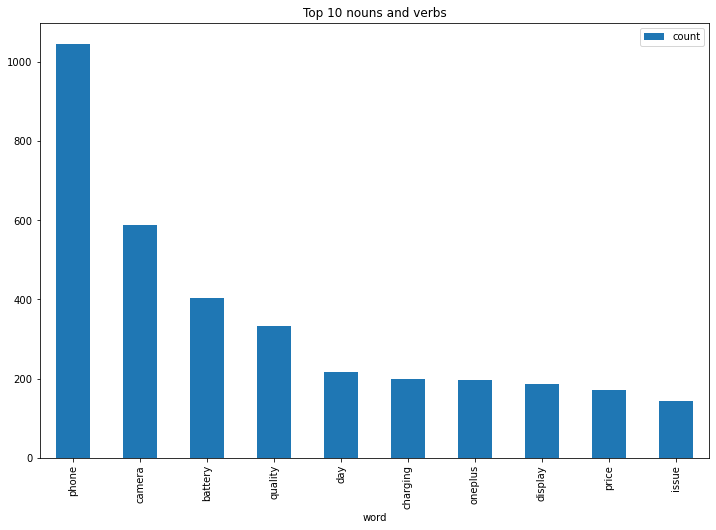

In [185]:
# Visualizing results (Barchart for top 10 nouns + verbs)
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs')

# Feature Extraction

In [186]:
# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

# Fetch sentiments

In [187]:
def fetch_sentiment_using_SIA(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'neg' if polarity_scores['neg'] > polarity_scores['pos'] else 'pos'

In [188]:
sentiments_using_SIA = dataframe.Clean_Reviews.apply(lambda tweet: fetch_sentiment_using_SIA(tweet))
pd.DataFrame(sentiments_using_SIA.value_counts())

,Clean_Reviews
pos,793
neg,186


In [189]:

dataframe.Clean_Reviews[8]

'buy phone amazon really bad exp dislike k poor build quality configuration real etc coming le k brand buy k audio worst single speaker volume low call end think phone mic issue back camera good phone touch also felt bit lack like fast charging within min charge front cam bit okay battery backup good g band support dual g standby oneplus promise something back camera quality audio improvement update buy offer otherwise go real gt master pro pro plus moto mobile also good using moto year good camera sound took two drawback phone rest okay manageble return policy replacement'

In [190]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(dataframe.Clean_Reviews[8])

{'neg': 0.147, 'neu': 0.613, 'pos': 0.24, 'compound': 0.8148}

In [192]:
#sid.polarity_scores(x.Clean_Reviews[8])

In [193]:
df=pd.DataFrame()
df['Review'] = dataframe.Clean_Reviews
df['scores'] = dataframe['Clean_Reviews'].apply(lambda review: sid.polarity_scores(review))
df.head()

,Review,scores
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou..."
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co..."
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp..."
3,handy light weight excellent voice clarity sig...,"{'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'comp..."
4,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co..."


In [194]:
df['compound']  = df['scores'].apply(lambda scores: scores['compound'])
df.head()

,Review,scores,compound
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co...",0.3818
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.9854
3,handy light weight excellent voice clarity sig...,"{'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'comp...",0.9826
4,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co...",0.9729


In [195]:
df['sentiment'] = df['compound'].apply(lambda c: 'Positive' if c >=0.05 else ('Negative' if c<=-0.05  else 'Neutral'))
df

,Review,scores,compound,sentiment
0,hang problem,"{'neg': 0.73, 'neu': 0.27, 'pos': 0.0, 'compou...",-0.4019,Negative
1,writing review using day honest normal android...,"{'neg': 0.103, 'neu': 0.744, 'pos': 0.153, 'co...",0.3818,Positive
2,camera good n fast phone back look awesomewith...,"{'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'comp...",0.9854,Positive
3,handy light weight excellent voice clarity sig...,"{'neg': 0.0, 'neu': 0.579, 'pos': 0.421, 'comp...",0.9826,Positive
4,medium could loaded average product decent day...,"{'neg': 0.051, 'neu': 0.648, 'pos': 0.301, 'co...",0.9729,Positive
...,...,...,...,...
974,give one star cause call rec annonce worst eve...,"{'neg': 0.158, 'neu': 0.615, 'pos': 0.227, 'co...",-0.0516,Negative
975,smooth look wise tooo good screen resolution g...,"{'neg': 0.0, 'neu': 0.572, 'pos': 0.428, 'comp...",0.9136,Positive
976,nice mobile,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215,Positive
977,good processor,"{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...",0.4404,Positive


<AxesSubplot:xlabel='sentiment', ylabel='count'>

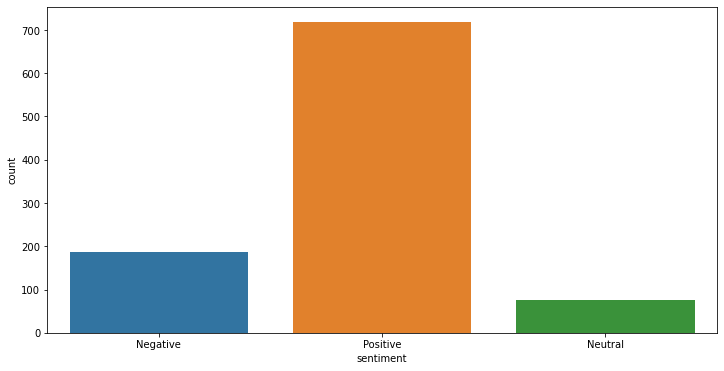

In [197]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)